### This notebook enables you to download Sentinel2 imagery (nbart and ao masks) from DEA AWSs3 repository.

- It produces a compostite image using the nbart bands,
- Checks if the requried directory structure exists, if it does not exist it will create it, 
- It then saves the nbart composite image and the two ao mask layers into the DCCEEW file store. 

In [1]:
import sys
import argparse
import urllib.request, json
import pandas as pd
import geopandas as gpd
import xarray as xr
import odc.aws
from pprint import pprint
from datacube.testutils.io import rio_slurp_xarray
import glob, os
import rasterio
import shutil
import pathlib

- provide the directory and path to save your imagery on your laptop 
- this notebook will download and process the imagery on your laptop, it keeps a local copy and then copies it into the corporate file store. 

In [2]:
# provide the path on your device you are saving the imagery too
local_dir = r'D:\\data\\working\\temp_image\\'
# path to the corporate file store 
file_store = r'D:\\data\\working\\sentinel2\\'
# cd to the local directory to download and process the imagery
os.chdir(local_dir)
print ('You are working in this directory: ',os.getcwd())

You are working in this directory:  D:\data\working\temp_image


In [3]:
# odc-stac library downloads DEA datasets stored in AWS
# when external to AWS (like outside DEA sandbox), AWS signed requests must be disabled
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [4]:
# load the Sentinel2 tile grid and select the tile of interest - edit the path to point at your local copy
s2g = gpd.read_file("D:\data\AUS_Sentinel2_Tiles_Geom\AUS_Sentinel2_Tiles_GeomBuff.shp")

select = s2g[(s2g['scene'] == 't51jvm')]

bbox = list(select.total_bounds)
print (bbox)

[122.5495054190026, -25.811351058701046, 122.55050068451305, -25.810448410265103]


In [14]:
"""Select the Sentinel2 a or b sensor"""
#product = 'ga_s2am_ard_3'
product = 'ga_s2bm_ard_3'

"""provide the start and finish dates"""
start_time = '2024-06-01'
end_time = '2024-06-30'
bbox = bbox

In [15]:
# the maximum number of images that will be returned is limited to 120 - if you what to see more increase the limit variable
root_url = 'https://explorer.dea.ga.gov.au/stac'
stac_url = f'{root_url}/search?collection={product}&time={start_time}/{end_time}&bbox={str(bbox).replace(" ", "")}&limit=120'
print(stac_url)

https://explorer.dea.ga.gov.au/stac/search?collection=ga_s2bm_ard_3&time=2024-06-01/2024-06-30&bbox=[122.5495054190026,-25.811351058701046,122.55050068451305,-25.810448410265103]&limit=120


In [16]:
with urllib.request.urlopen(stac_url) as url:
    data = json.loads(url.read().decode())
pprint(data, depth=1)

{'context': {...},
 'features': [...],
 'links': [...],
 'numberMatched': 2,
 'numberReturned': 2,
 'type': 'FeatureCollection'}


<AxesSubplot:>

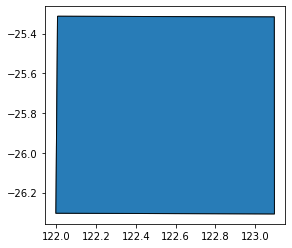

In [17]:
# Convert features to a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(data['features'])

# Plot the footprints of each dataset
gdf.plot(alpha=0.8, edgecolor='black')

In [18]:
gdf

,geometry,title,gsd,created,gqa:abs_x,gqa:abs_y,gqa:cep90,proj:epsg,fmask:snow,gqa:abs_xy,...,gqa:abs_iterative_mean_x,gqa:abs_iterative_mean_y,gqa:abs_iterative_mean_xy,sentinel:sentinel_tile_id,sentinel:datatake_start_datetime,cubedash:region_code,datetime,sentinel:utm_zone,sentinel:grid_square,sentinel:latitude_band
0,"POLYGON ((122.00612 -25.31284, 123.09697 -25.3...",ga_s2bm_ard_3-2-1_51JVM_2024-06-08_final,10.0,2024-06-20T16:27:36.913336Z,0.35,0.29,0.52,32751,1.226220,0.45,...,0.28,0.21,0.35,S2B_OPER_MSI_L1C_TL_2BPS_20240608T032724_A0378...,2024-06-08T03:27:24Z,51JVM,2024-06-08T02:04:46.570050Z,NaN,NaN,NaN
1,"POLYGON ((122.00612 -25.31284, 123.09697 -25.3...",ga_s2bm_ard_3-2-1_51JVM_2024-06-18_nrt,10.0,2024-06-18T08:58:35.565903Z,3.70,8.28,11.96,32751,0.151559,9.07,...,2.29,9.08,9.36,S2B_OPER_MSI_L1C_TL_2BPS_20240618T032606_A0380...,2024-06-18T03:26:06Z,51JVM,2024-06-18T02:04:46.180127Z,51.0,VM,J


In [21]:
# This enables you to query the imagery available and remove the images with higher than acceptable cloud.
# beware that this is an estimate of cloud cover in the imagery and sometimes it is not particularly accurate. 
# If you don’t care about cloud cover and want to download or look at all the imagery available un-hash line six.

cl = gdf[(gdf['eo:cloud_cover'] < 1)]

cl = gdf
print (cl.index)

RangeIndex(start=0, stop=2, step=1)


### You can now inspect the thumbnail for each of the images in your selected query. 
- The image index and name are printed out along with the thumbnail 

index: 0  Image: ga_s2bm_nbart_3-2-1_51JVM_2024-06-08_final_thumbnail.jpg


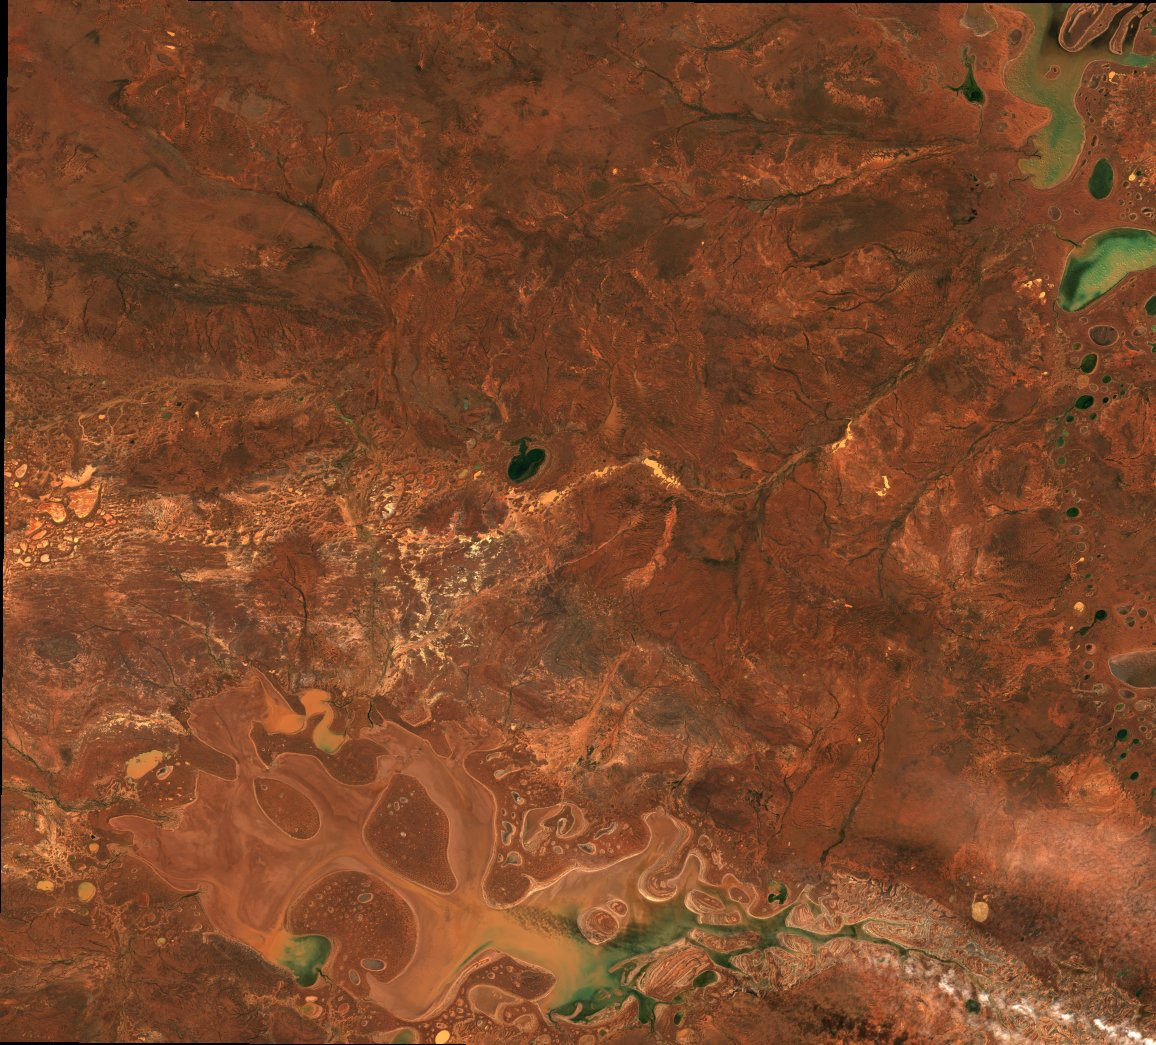

index: 1  Image: ga_s2bm_nbart_3-2-1_51JVM_2024-06-18_nrt_thumbnail.jpg


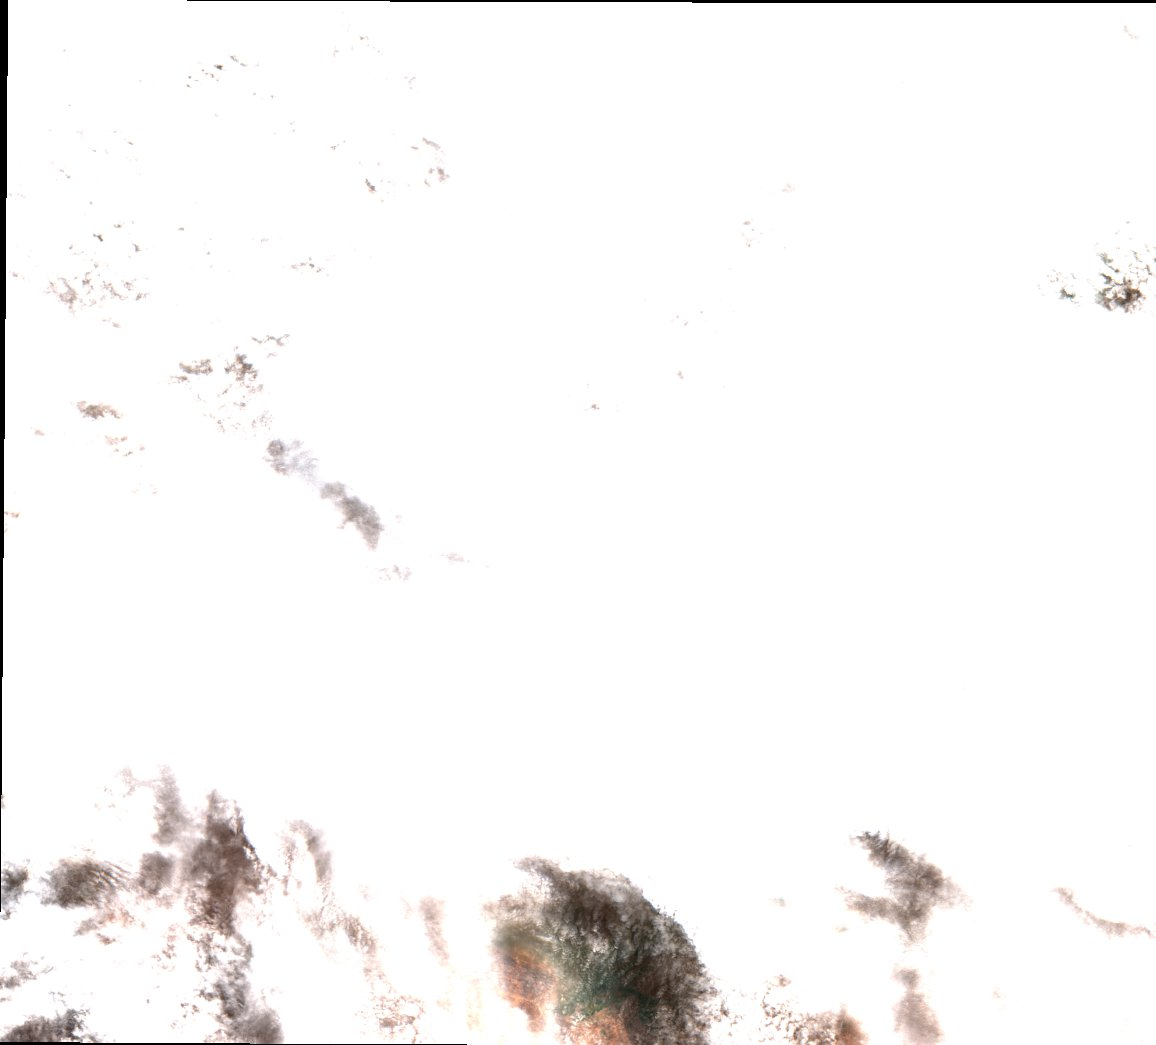

In [22]:
from IPython.display import Image

# for some reason DEA have decided to not provide thumbnails for some image dates (annoying!)
# the error will be ignored so be aware that you will only see the thumbnails that are avilable!

for i in cl.index:        
    try:
        stac_item = data['features'][i]
        url = stac_item['assets']['thumbnail:nbart']['href']
        jpg = odc.aws.s3_download(url)
        print ('index:',i ,' Image:', jpg)
        display(Image(filename=jpg,width = 800, height = 800))
        os.remove(jpg)
    except:
        pass

### You have two options when selecting which imagery to download;
1. Download everything (be careful this code will automatically download and process every image in your stac query)   
2. Download a single of multiple scenes based on the index.


In [23]:
"""
Select the imagery you want to download by editing the intergers in the select variable 

Single example: select = [0] 
multiple example: select = [0,4,23]
"""
select = [70]

"""un-hash the next line to download and process all imagery returned in your stac query """
#select = cl.index

### Download and process the selected imagery to produce a composite image from the four Sentinel2 10m bands and associated mask layers. 
- The code will automatically download all the selected imagery onto your local working drive and then file them on the corporate file store. Note: it may take some time to copy the imagery to the corporate file store.  
- By default this code will download the nbart product, if you require the nbar product un-hash the bands list below

In [24]:
# nbart band list
bands = ['nbart_blue','nbart_green','nbart_red','nbart_nir_1']

# nbar band list
#bands = ['nbar_blue','nbar_green','nbar_red','nbar_nir_1']

oa = ['oa_fmask','oa_combined_terrain_shadow']

for i in select:
    
    stac_item = data['features'][i]
    urls = [asset['href'] for asset in stac_item['assets'].values()]
    
    # make a directory to save the current S2 image into
    image_dir = (str(cl['title'][i]))
       
    os.makedirs(image_dir)
    os.chdir(image_dir)
    print (os.getcwd())
        
    for band in bands:
        url = stac_item['assets'][band]['href']
        odc.aws.s3_download(url)
        
    file_list = []
    
    for file in glob.glob("*.tif"):
        print (file)
        file_list.append(file)
    
    comp_file_name = file_list[0][:-10] + 'comp.tif'
    
    band_list = file_list

    # Read metadata from the first band in the composite image
    with rasterio.open(band_list[0]) as src0:
        meta = src0.meta

    # Update metadata to reflect the number of layers
    meta.update(count= len(band_list))

    # Read each layer and write it to stack
    with rasterio.open(comp_file_name, 'w', **meta, compress='lzw') as dst:
        for id, layer in enumerate(band_list, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
                
    for file in band_list:
        os.remove(file) 
    print("Individual bands have been deleted") 
    
    # now download the two mask products - if for some reason either of the two mask products are not available the script will carry on its merry way 
    for file in oa:
        try:
            url = stac_item['assets'][file]['href']
            odc.aws.s3_download(url)
        except:
            pass

    # move the files to the coporate storage location once all files have been downloaded and processed 
        
    def make_dir(directory):
        """ Check if the directory already exists and create it if required.

        :param directory: string object containing the directory for the Sentinel2 imagery.
        """
        check_dir = os.path.exists(directory)
        if check_dir:
            pass
        else:
            os.mkdir(directory)
            print('directory created..')
        
    scratch_dir = str(os.getcwd())  
    
    # path to the DCCEEW coporate directory to store the imagery
    path = file_store 
    
    # look for the imagery processed and create the file path and check if it already exists, if not it will be created. 
    for file in glob.glob("{0}\\*.tif".format(scratch_dir)):
    
        file_list_ = file.rsplit('\\', 1)
        file_name = file_list_[1]
       
        file_list = file_name.split('_')
        
        tile1 = file_list[4][:-2].lower()
    
        tile2 = file_list[4].lower()

        file_date = file_list[5]        
        
        file_date_list = file_date.split('-')

        file_year = file_date_list[0]
        
        file_month_ = file_date_list[0] + file_date_list[1]

        newTile1 = os.path.join(path, tile1)

        make_dir(newTile1)
        
        newTile2 = os.path.join(path, tile1, tile2) 
        
        make_dir(newTile2)
        
        newTile_year = os.path.join(path, tile1, tile2, file_year)

        make_dir(newTile_year)
          
        newTile_year_month = os.path.join(path, tile1, tile2, file_year, file_month_)
        
        make_dir(newTile_year_month)
 
        # format the new directory path to put the file into
        output = '{0}\\{1}'.format(newTile_year_month, file_name)

        print('-- file: ', file)
        
        if os.path.exists(file):
            if os.path.exists(output):
                print('- ', file)
                print('-- Already exists')

            else:
                shutil.copy(file, output)
                print('- ', file)
                print('-- Copied to: ', output)    
 
    os.chdir("..")
    print (os.getcwd())

D:\data\working\temp_image\ga_s2bm_ard_3-2-1_51JVM_2024-06-08_final
ga_s2bm_nbart_3-2-1_51JVM_2024-06-08_final_band02.tif
ga_s2bm_nbart_3-2-1_51JVM_2024-06-08_final_band03.tif
ga_s2bm_nbart_3-2-1_51JVM_2024-06-08_final_band04.tif
ga_s2bm_nbart_3-2-1_51JVM_2024-06-08_final_band08.tif
Individual bands have been deleted
directory created..
directory created..
directory created..
directory created..
-- file:  D:\data\working\temp_image\ga_s2bm_ard_3-2-1_51JVM_2024-06-08_final\ga_s2bm_nbart_3-2-1_51JVM_2024-06-08_final_comp.tif
-  D:\data\working\temp_image\ga_s2bm_ard_3-2-1_51JVM_2024-06-08_final\ga_s2bm_nbart_3-2-1_51JVM_2024-06-08_final_comp.tif
-- Copied to:  D:\\data\\working\\sentinel2\\51j\51jvm\2024\202406\ga_s2bm_nbart_3-2-1_51JVM_2024-06-08_final_comp.tif
-- file:  D:\data\working\temp_image\ga_s2bm_ard_3-2-1_51JVM_2024-06-08_final\ga_s2bm_oa_3-2-1_51JVM_2024-06-08_final_combined-terrain-shadow.tif
-  D:\data\working\temp_image\ga_s2bm_ard_3-2-1_51JVM_2024-06-08_final\ga_s2bm_oa_3